In [ ]:
import pandas as pd

# Specify the path to your CSV file
csv_file_path = r"C:\Users\ojmar\Documents\Uni\StammerScore\ml-stuttering-events-dataset\SEP-28k_labels.csv"

# Use pandas to read the CSV file
df = pd.read_csv(csv_file_path)

cols_to_avg = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'DifficultToUnderstand', 'Interjection']
df['avg'] = df[cols_to_avg].mean(axis=1)

# Assign values to "Fluency Label" based on the calculated average
df['Fluency Label'] = (df['avg'] <= 0.4).astype(int)

# Drop the temporary average column if not needed
df.drop(columns=['avg'], inplace=True)

# Display the DataFrame to verify the results
print(df.head())

In [28]:
# Remove rows where the Show value is "StrongVoices"
df = df.loc[df['Show'] != 'StrongVoices']

In [29]:
# Define the base path where the clips are stored
base_path = r"C:\Users\ojmar\Documents\Uni\StammerScore\ml-stuttering-events-dataset\[CLIP_DIR]"

# Function to generate the file path for each row
def generate_clip_path(row):
    # Format the path using the Show, EpId, and ClipId, ensuring EpId and ClipId are integers
    return f"{base_path}\\{row['Show']}\\{int(row['EpId'])}\\{row['Show']}_{int(row['EpId'])}_{int(row['ClipId'])}.wav"

# Apply the function to each row of the DataFrame to create a new column 'ClipPath'
df['ClipPath'] = df.apply(generate_clip_path, axis=1)

# Display the DataFrame to verify the new column
print(df.head())


         Show  EpId  ClipId     Start      Stop  Unsure  PoorAudioQuality  \
0  HeStutters     0       0  31900320  31948320       0                 0   
1  HeStutters     0       1  31977120  32025120       0                 0   
2  HeStutters     0       2  34809760  34857760       0                 0   
3  HeStutters     0       3  35200640  35248640       0                 0   
4  HeStutters     0       4  35721920  35769920       0                 0   

   Prolongation  Block  SoundRep  WordRep  DifficultToUnderstand  \
0             0      0         0        0                      0   
1             0      0         0        0                      0   
2             0      0         0        0                      0   
3             1      0         0        0                      0   
4             0      0         0        0                      0   

   Interjection  NoStutteredWords  NaturalPause  Music  NoSpeech  \
0             0                 3             1      0      

# Preprocessing Audio Data

Audio Normalization: Ensure all audio clips are at a consistent volume level.
Sampling Rate Consistency: Convert all audio files to the same sampling rate if they differ.
Audio Length: Consider making all audio clips the same length either by trimming or padding shorter clips.
Feature Extraction: Convert audio signals into a form that machine learning algorithms can work with. Common features include Mel-frequency cepstral coefficients (MFCCs), spectrograms, or even raw waveforms for deep learning models.

## Audio Normalization

In [30]:
import librosa

# Function to calculate RMS of an audio clip
def calculate_rms(audio_path):
    y, _ = librosa.load(audio_path)
    rms = librosa.feature.rms(y=y).mean()
    return rms

# Calculate RMS for each clip and append it to the DataFrame
df['RMS'] = df['ClipPath'].apply(calculate_rms)

# Display the updated DataFrame
print(df.head())


         Show  EpId  ClipId     Start      Stop  Unsure  PoorAudioQuality  \
0  HeStutters     0       0  31900320  31948320       0                 0   
1  HeStutters     0       1  31977120  32025120       0                 0   
2  HeStutters     0       2  34809760  34857760       0                 0   
3  HeStutters     0       3  35200640  35248640       0                 0   
4  HeStutters     0       4  35721920  35769920       0                 0   

   Prolongation  Block  SoundRep  WordRep  DifficultToUnderstand  \
0             0      0         0        0                      0   
1             0      0         0        0                      0   
2             0      0         0        0                      0   
3             1      0         0        0                      0   
4             0      0         0        0                      0   

   Interjection  NoStutteredWords  NaturalPause  Music  NoSpeech  \
0             0                 3             1      0      

In [34]:
df['RMS'].describe()

count    25869.000000
mean         0.048424
std          0.029405
min          0.000221
25%          0.027370
50%          0.044128
75%          0.064212
max          0.308333
Name: RMS, dtype: float64

In [32]:
output_file_path = 'RMS values.csv'
df.to_csv(output_file_path, index=False)

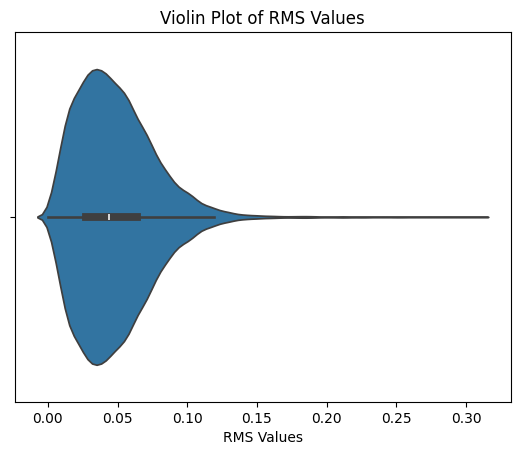

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the violin plot
sns.violinplot(x=df['RMS'])

# Adding titles and labels (optional, but recommended for clarity)
plt.title('Violin Plot of RMS Values')
plt.xlabel('RMS Values')

# Display the plot
plt.show()

Next steps:
Determine the Target RMS Value: Decide on a target RMS value to normalize all clips to. This could be based on your application's specific needs or preferences. A common approach is to use the average RMS value across all clips, but you might choose a different target, such as the 75th percentile, to preserve more of the dynamic range in the clips.

Calculate the Adjustment Factor: For each audio clip, calculate the adjustment factor needed to bring its RMS value to the target level. The adjustment factor is the ratio of the target RMS to the clip's current RMS.

Apply the Adjustment Factor: Adjust each clip's volume by multiplying its audio signal by the calculated adjustment factor. This operation should normalize the RMS value of the clip to the target level.

Consider Clipping: Ensure that the normalization process does not cause any audio clip to clip (i.e., exceed the maximum amplitude allowed in the audio format). If the adjusted signal exceeds this limit, you might need to apply dynamic range compression or limit the gain applied to prevent clipping.

In [ ]:
import numpy as np

# Assuming `audio_signals` is a list where each element is a numpy array representing an audio clip
# and `target_rms` is the RMS level you want to normalize all clips to

def calculate_rms(audio_signal):
    return np.sqrt(np.mean(np.square(audio_signal)))

def normalize_audio_clips(audio_signals, target_rms):
    normalized_signals = []
    for signal in audio_signals:
        current_rms = calculate_rms(signal)
        adjustment_factor = target_rms / current_rms
        # Apply adjustment factor, with a check to prevent clipping
        normalized_signal = np.minimum(signal * adjustment_factor, 1.0)
        normalized_signals.append(normalized_signal)
    return normalized_signals

# Example target RMS
target_rms = 0.05  # This value should be chosen based on your specific needs

# Normalize all clips (this is a conceptual example; implementation details may vary)
normalized_audio_clips = normalize_audio_clips(audio_signals, target_rms)


# Modelling

In [37]:
simple_df = df[['ClipPath', 'Fluency Label']]

print(simple_df.describe())


       Fluency Label
count   25869.000000
mean        0.496424
std         0.499997
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000


In [38]:
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Feature extraction
def extract_features(audio_path):
    y, sr = librosa.load(audio_path)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
    # You can add more features here
    return mfccs

# Assuming ClipPath contains the full path to the audio files
features = np.array([extract_features(path) for path in simple_df['ClipPath']])
labels = simple_df['Fluency Label'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy:.2f}')

# Model is now ready to predict fluency labels


Model Accuracy: 0.61


In [40]:
from sklearn.metrics import f1_score
# Calculate and print the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Model F1 Score: {f1:.2f}')

Model F1 Score: 0.61


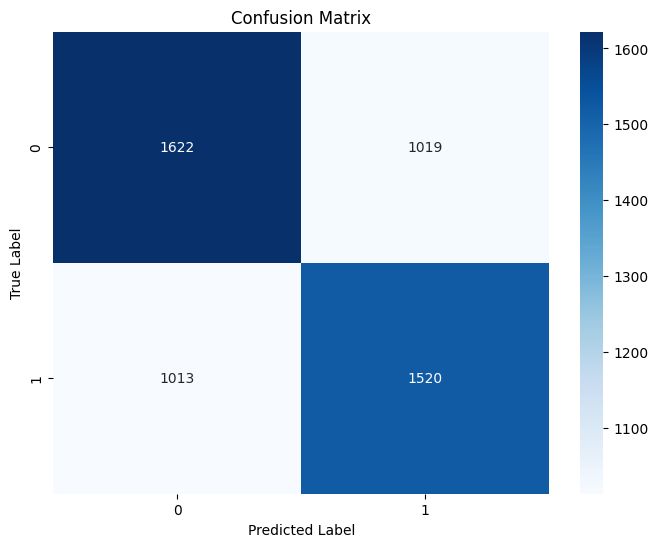

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Usage

In [42]:
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler
# Replace the following with your actual model import and loading
# from your_model_library import YourModelClass
# model = YourModelClass.load('path_to_your_trained_model')

# Assuming model is already loaded in the environment for this example
# model = ...

# Feature extraction function
def extract_features_usage(audio_signal, sr):
    mfccs = np.mean(librosa.feature.mfcc(y=audio_signal, sr=sr, n_mfcc=13), axis=1)
    # You can add more features here
    return mfccs

# Function to split the audio signal into chunks of 3 seconds
def split_audio_signal(y, sr, chunk_length=3):
    chunk_size = chunk_length * sr  # Chunk size in samples
    chunks = [y[i:i + chunk_size] for i in range(0, len(y), chunk_size) if i + chunk_size <= len(y)]
    return chunks

# Function to make predictions on chunks and calculate final score
def predict_and_score(audio_path, model):
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=None)
    # Split the audio signal into 3-second chunks
    chunks = split_audio_signal(y, sr)
    
    # Extract features and predict for each chunk
    scaler = StandardScaler()  # Assume you used StandardScaler during training
    predictions = []
    for chunk in chunks:
        features = extract_features_usage(chunk, sr)
        features = scaler.fit_transform(features.reshape(1, -1))  # Scaling the features
        predictions.append(model.predict(features)[0])
    
    # Calculate the final fluency score (you might want to use a different formula here)
    fluency_score = np.mean(predictions)
    
    return fluency_score

# Example: Predict the fluency score of an audio file
audio_file_path = r'C:\Users\ojmar\Documents\Uni\StammerScore\ml-stuttering-events-dataset\test_audio\do-schools-kill-creativity-sir-ken-robinson-ted.wav'
final_score = predict_and_score(audio_file_path, model)
print(f"The final fluency score is: {final_score}")



The final fluency score is: 1.0
